In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import math

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import mean_squared_error

Using Theano backend.


## Introduction
Technical analysis is a trading discipline used to evaluate investments and identify trading opportunities in price trends and patterns from graphs.  Technical analysts believe past trading activity and price changes of a stock can be indicators of the security's future price movements.  The difference between 
technical analysis and fundamental analysis is that fundamental analysts focuses on a company's financials rather than historical price patterns or stock trends.  https://www.investopedia.com/terms/t/technicalanalysis.asp<br>
This notebook will demonstrate how to perform a very basic technical analysis of stock prices using Python code.  I will provide analysis and insights of stock prices that can be obtained from historical stock data and corresponding graphs.  In addition, this notebook will demonstrate how algorithmic trading can be used to predict stock prices and how technical indicators can used with LTSM models.<br>
I obtained the historical stock data by using the Pandas library DataReader.  The library provides price and volume information regarding stocks. I will use mainly the Adjusted Closing Price ('Adj Close') from the datasets.<br>
In addition, I will use the Long Short Term Memory (LSTM ) and SARIMA models to forecast the next day stock price.  I will use the calculations from the technical indicators for forecasting.  I will use  metrics to measure the performance of the models at predicting stock prices.  
The data will consist of the following pharmaceutical companies that are developing a COVID-19 vaccine: 
* Pfizer (PFE),
* Johnson & Johnson (JNJ)
* Moderna (MRNA)
* Novavax (NVAX) 
* BioNTech SE (BNTX)
* MERCK & Co. (MRK)

What are technical Indicators?  Technical indicators are quick methods or mathematical calculations based on the price, volume, or open interest of a security or contract used by traders who follow technical analysis. https://www.investopedia.com/terms/t/technicalindicator.asp Technical indicators are signals produced from the patterns observed in the movements of stock prices (high, low, open, close) and volumes.  These signals are in turn used to predict the future price movements. Techincal Indicators as used in this notebook will provide a historical price analysis  regarding volatility and trends of the stock.  Technical indicators are a fundamental part of technical analysis and are typically plotted as a chart pattern to try to predict the market trend.<br>
Some basic examples of technical indicators which I will cover are:
1. Simple Moving Averages (SMA)
2. Exponential Moving Averages (EMA)
3. Moving Average Convergence Divergence (MACD) Crossover Strategy
4. Relative Strength Index

My technical analysis of the stock prices will focus on answering the following questions  which concern price trends, volatility and forecasting:
### Question 1: 
Can technical indicators provide an investor or trader with information to make a decision of when to buy and sell stocks?<br>
**Answer**: Yes. 
Investment decisions are very complicted and require knowledge and consideration of many variables which are beyond the scope of this notebook.  Technical indicators are tools used by investors and traders to gain insights regarding the stock's history, volatility, trends and the direction the price may be headed.    I will use Moving Averages, prices changes and MACD to analyze price trends.  A question to always consider is what type of investment is being sought?  Are you looking for short investments with high returns or long term investment with consistent returns.<br>
<br>
**Model 1** A Simple Moving Average Plot with a rolling average of 10 and 50 days.<br> 
**Model 2**  An Exponential Moving Average Plot.<br>
**Model 3**  Exponential Moving Average Crossover Stratergy<br>
**Model 4**  Relative Strength Index Plot

### Question 2:
How well do LSTM algorithms perform when used to forecast future stocks prices?  I will contrast the performance of LSTM models with data from the above technical indicators.  I will use the RMSE metric to compare the models' performances?<br>
**Model 1** I will use a LTSM Neural Network to make a price prediction with only historical price data.<br>
**Model 2** LTSM model with technical indicators to predict and graph future stock prices.<br>
### Question 3:
Which trading algorithms perform better at predicting stocks prices, LTSM or ARIMA?  I will compare results of both algorithms.<br> 
**Answer:** <br>
**Model 1** is a SARIMA model.<br>


## Historical Stock Data

### Multiple Stocks Data (multi_stocks)

In [2]:
from datetime import date
today = date.today()
def multiple_stock_data(ticker=None, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            label_font = {'weight':'bold','size':18}
            plt.title("Historical Adjusted Price Data",fontdict=label_font)
            plt.xlabel('Dates')
            plt.ylabel('Stocks Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


Symbols,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,103.436539,25.400000,NaN,23.433638,NaN
2017-01-04,26.887548,103.266876,26.200001,NaN,23.619688,NaN
2017-01-05,27.146002,104.347321,26.400000,NaN,24.262403,NaN
2017-01-06,27.041008,103.847282,27.400000,NaN,24.042524,NaN
2017-01-09,27.032928,103.829422,28.400000,NaN,24.127094,NaN
...,...,...,...,...,...,...
2021-03-17,35.790001,160.770004,225.460007,147.550003,50.070000,106.660004
2021-03-18,35.770000,160.470001,217.259995,141.460007,49.330002,103.650002
2021-03-19,35.529999,160.039993,228.250000,143.740005,49.209999,107.589996


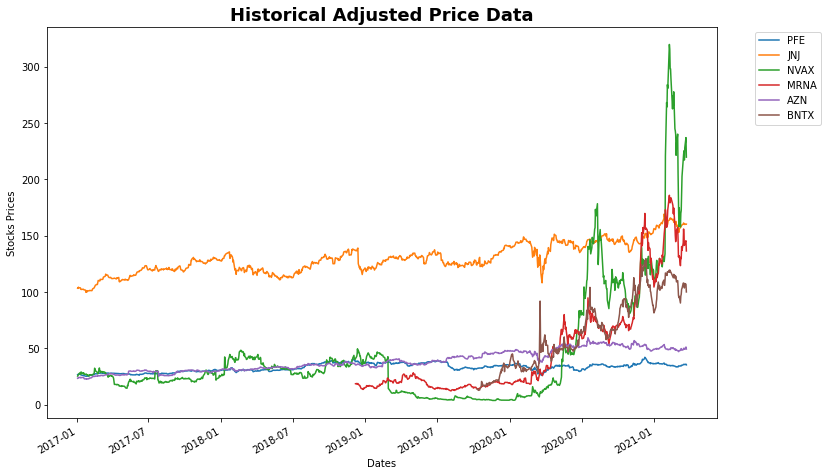

In [3]:
multi_stock_data = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=True, stock_value='Adj Close')
multi_stock_data

In [4]:
multi_stock_data.to_csv('multi_pharm_data')

In [5]:
#start='2017',end='today'
multi_stocks = pd.read_csv('multi_pharm_data', parse_dates=True, index_col='Date')

#### Multiple Stock Plot

In [6]:
def multi_plot(df, stock_value=None):
    #plt.figure(figsize=(12,8))
    df.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'Historical {stock_value} Price',fontdict=label_font)            

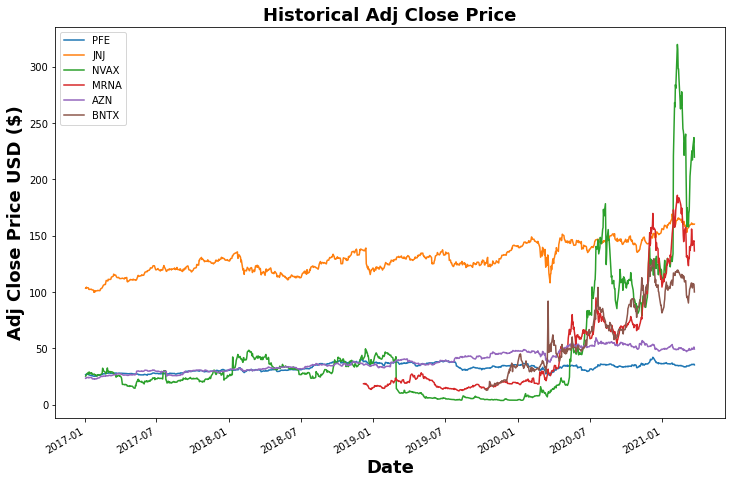

In [7]:
multi_plot(multi_stocks, stock_value='Adj Close')

In [8]:
multi_stocks.describe()

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
count,1062.000000,1062.000000,1062.000000,576.000000,1062.000000,365.000000
mean,32.888265,129.831293,43.660264,49.845373,38.636431,64.642192
std,3.679710,13.578463,51.596898,44.502957,9.157226,31.673563
min,25.159119,99.793396,3.690000,12.260000,22.596422,12.750000
25%,30.064301,120.283634,12.747500,17.827500,30.833803,36.599998
50%,33.176151,128.271461,27.100000,23.770000,36.447330,61.990002
75%,36.042671,139.588810,42.599998,69.482500,47.297837,91.160004
max,42.101986,169.423508,319.929993,185.979996,59.466022,129.539993


### Single Stock Data (pfe_stock_data)

In [9]:
def single_stock_data(symbol, start,end=None,plot=True,stock_value='Adj Close'):
    
    try:
        
        df = web.DataReader(symbol,'yahoo', start, end)
        df_single = pd.DataFrame(df)
        print("Dataframe has {} rows and {} columns".format(df_single.shape[0],df_single.shape[1]))
        print()
        if plot==True:
            plt.figure(figsize=(12,8))
            plt.plot(df_single[stock_value])
            label_font = {'weight':'bold','size':18}
            plt.xlabel('Date',fontdict=label_font)
            plt.ylabel('Close Price USD ($)',fontdict=label_font)
            plt.title(f'Historical {stock_value} Price for {symbol}',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
        return df_single
        
    except Exception as e:
        #if inccorect symbol is inputted, error message displayed
        print("Error occured/Incorrect Symbol:", e)
        #data = 'Incorrect Symbol'


This is data for Pfizer.

Dataframe has 1062 rows and 6 columns



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,31.309298,30.920303,31.024668,31.309298,23391844.0,26.653324
2017-01-04,31.641365,31.337761,31.432638,31.584440,22753963.0,26.887548
2017-01-05,31.963947,31.423149,31.660341,31.888046,21083584.0,27.146002
2017-01-06,31.973434,31.631880,31.935484,31.764706,18418228.0,27.041008
2017-01-09,31.944971,31.669828,31.717268,31.755219,21559886.0,27.032928
...,...,...,...,...,...,...
2021-03-17,35.959999,35.119999,35.830002,35.790001,42299500.0,35.790001
2021-03-18,35.970001,35.520000,35.529999,35.770000,24716200.0,35.770000
2021-03-19,35.820000,35.470001,35.750000,35.529999,48256600.0,35.529999


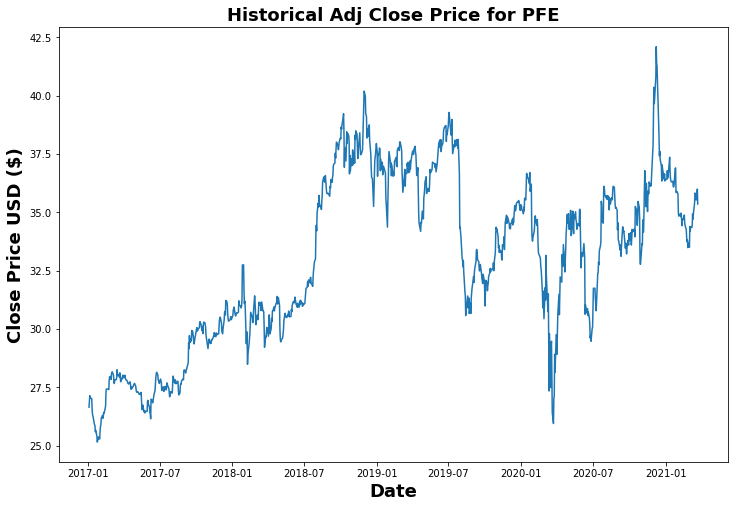

In [10]:
start='01-01-2017'
end='today'
pfe_stock = single_stock_data('PFE', start= start,end='today',plot=True,stock_value='Adj Close')
pfe_stock

In [11]:
pfe_stock.to_csv('pfe_stock')
pfe_stock_df = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')
#single_stock['Close']['2015-04-01':'2015-12-01'].plot()
pfe_stock_data = pfe_stock_df[['Close','Volume','Adj Close']]

In [12]:
pfe_stock_data.describe()

,Close,Volume,Adj Close
count,1062.000000,1.062000e+03,1062.000000
mean,35.578524,2.606708e+07,32.888265
std,3.290932,1.370330e+07,3.679710
min,27.030361,5.187683e+06,25.159119
25%,33.432164,1.813847e+07,30.064301
50%,34.824612,2.277989e+07,33.176151
75%,37.747500,2.955548e+07,36.042671
max,43.861481,2.301539e+08,42.101986


#### Single Stock Plot

In [13]:
def single_plot(df,stock_value=None, stock_symbol=None):
    df[stock_value].plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'{stock_symbol} {stock_value} History',fontdict=label_font)                

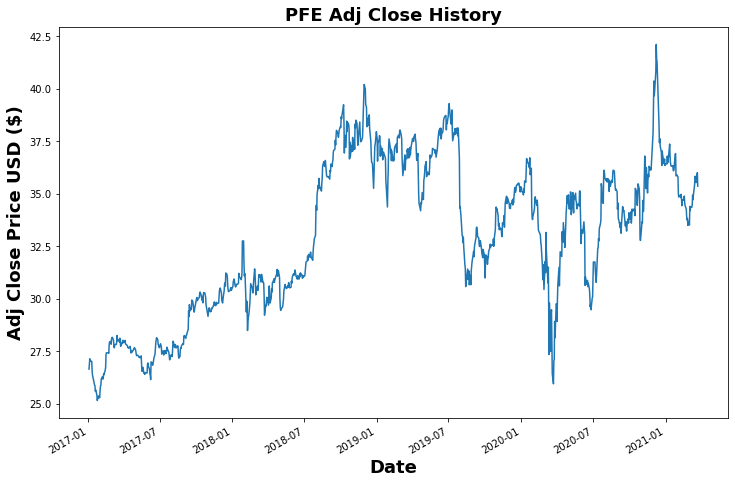

In [14]:
single_plot(pfe_stock_data, stock_value='Adj Close', stock_symbol='PFE')

In [15]:
pfe_stock_data['Adj Close'].describe()

count    1062.000000
mean       32.888265
std         3.679710
min        25.159119
25%        30.064301
50%        33.176151
75%        36.042671
max        42.101986
Name: Adj Close, dtype: float64

## Technical Indicators
The practice of analyzing and executing stock trades is becoming increasingly automated with algorithimic trading.  The usage of technnical indicators is part of algorithmic trading. What are technical indicators and how are they used by Technical Analyst in stock trading?  Technical indicators are methods or pattern-based signals produced by the price, volume, and/or open interest of a stock which are used by traders who follow technical analysis.  Technical analysts believe past trading activity and price changes of a security can be valuable indicators of the security's future price movements. https://www.investopedia.com/terms/t/technicalindicator.asp<br>Technical analysts look for indicators in the historical data and use them to predict future price movements.  The analysts also use them to look for entry and exit points in markets to conduct trades.  I will discuss the below popular technical indicators which are used in the markets to study price movements:

1. Moving Averages (MA)
    > Simple Moving Average<br>
    > Exponential Moving Average<br>
2. Rate of Change (ROC)
3. Relative Strength Index (RSI)

### Moving Averages
The moving average is also known as the rolling mean or running average.  Moving averages smooth out the curve by filtering out the noise inorder to highlight components in the data such as trends and seasonality.  The moving Average smooths out the variations in the dataset by calculating the moving average.  Two common types of moving averages are Simple Moving Average (SMA), and Exponential Moving Average (EMA). <br>

#### Simple Moving Average
The Simple Moving Average is the arithmetic mean of all the stock prices or the sum of all the stock prices divided by the number of periods.  We can use the Python rolling method to calculate moving averages.  SMA calculates the average of prices over a given interval of time and is used to determine the trend of the stock. Common time periods used for moving averages are 5, 10, 20, 50, 200 days.  A 10 time period SMA would mean 10 trading days.  We are considering the past 10 and 50 days and averaging each group, so there won't be any results for the begining entries.<br>  
The below graph looks like the stock price is volatile with lots of fluctuations and noise.  The plot shows the average stock price with the 10 and 50-day moving averages.  The 10-day follows the Adj Close price but smooths out the positve and negative spikes in prices.<br>
Aound 2/18, there was a spike in price from \\$35.00 to almost \\$37.50 and then dropped quickly to almost \\$32.00.  What is the SMA showing us?  SMA gives a more realistic picture of what happened with stock the price. The price increased and dropped precipitously.  We may not know what precipitated such activity, but what were the 10 and 50 day averages around this time period for a more accurate picture of what the stock price was for that period?  How does this compare to performance of the stock in general?  The average price of the stock was \\$35.578.  When applying the 10 and 50-day Moving Averages the average price is still \\$35.00.  So is the stock price really that volatile? <br>  <br>What's interesting is that if we do subsets of for time period of 2/18 to for 10 and 50 averages we see that the average price was still around \\$35.00.<br>  We can see that with the subset of 50 day rolling average data the stock's average price was \\$30.26.
Around 8/2019, the price was pretty volatile.  The SMA smooths out the noise and gives a more accurate picture.<br>

##### Qestion 1 / Model 1

##### Moving Average Convergence/Divergence Cross Over Stategy
The MACD can used for the SMAs.  The 50-day moving average is the one that takes longer to adjust to sudden price changes, while the 10-day one is much faster to account for sudden changes.  In the code below I am defining buying and selling signals for the crossover strategy.
The logic of the strategy is as follows:
when the fast MA crosses the slow one upwards, we buy the asset
when the slow MA crosses the fast one upwards, we sell the asset

In [16]:
sma_func_calc = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')

In [17]:
def sma_function(data, col1=None, col2=None, col3=None, symbol=None):
    data[col2] = data[col1].rolling(10).mean()
    data[col3] = data[col1].rolling(50).mean()

    data['Signal'] = 0.0
    data['Signal'] = np.where(data[col2] > data[col3], 1.0, 0.0)
    data['Position'] = data['Signal'].diff()

    data = data.dropna()
    
    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data[col1].plot(color = 'blue', label= 'Close Price',alpha=0.5) 
    data[col2].plot(color = 'red',label = '10-day SMA') 
    data[col3].plot(color = 'green', label = '50-day SMA')
    label_font = {'weight':'bold','size':18}
    plt.title(f'{symbol} SMA',fontdict=label_font)
    plt.ylabel('Stock Price', fontsize = 15,fontdict=label_font)
    plt.xlabel('Date',fontdict=label_font)

    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data[col1].plot(color = 'blue', label= 'Close Price',alpha=0.5) 
    data[col2].plot(color = 'red',label = col2) 
    data[col3].plot(color = 'green', label = col3)
    # plot ‘buy’ signals
    plt.plot(data[data['Position'] == 1].index, 
             data[col2][data['Position'] == 1], 
             '^', markersize = 10, color = 'green', label = 'buy')
    # plot ‘sell’ signals
    plt.plot(data[data['Position'] == -1].index, 
             data[col2][data['Position'] == -1], 
             'v', markersize = 10, color = 'red', label = 'sell')
    
    plt.ylabel('Stock Price', fontsize = 15,fontdict=label_font)
    plt.xlabel('Date',fontdict=label_font)
    plt.title(f'{symbol} SMA Crossover Stategy',fontdict=label_font)
    plt.legend(loc='best',fontsize=14)
    plt.grid()
    plt.show()
    
    return data

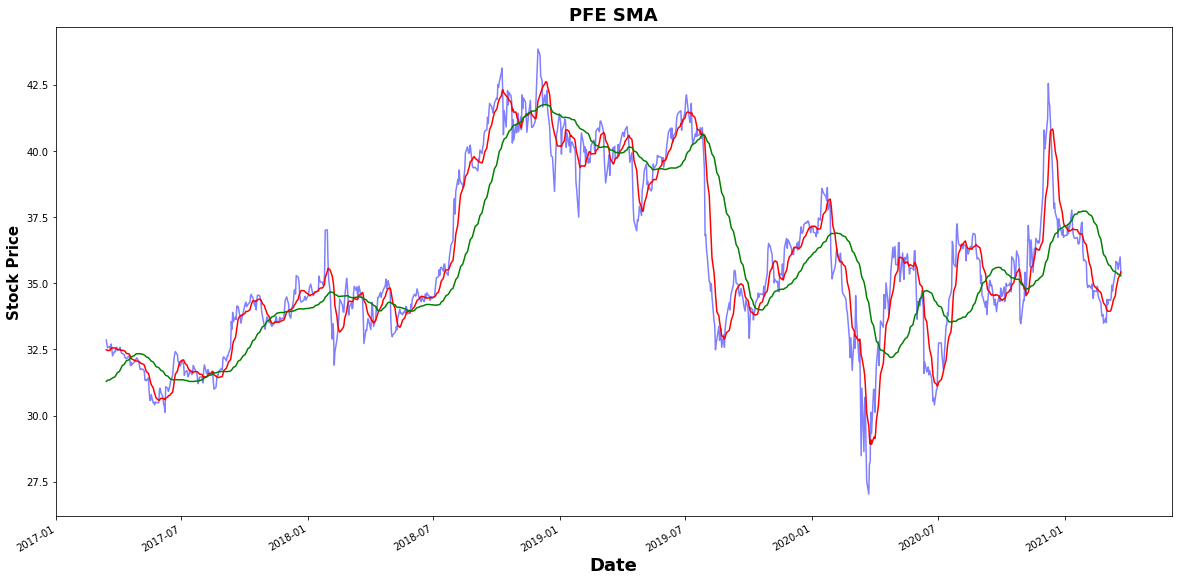

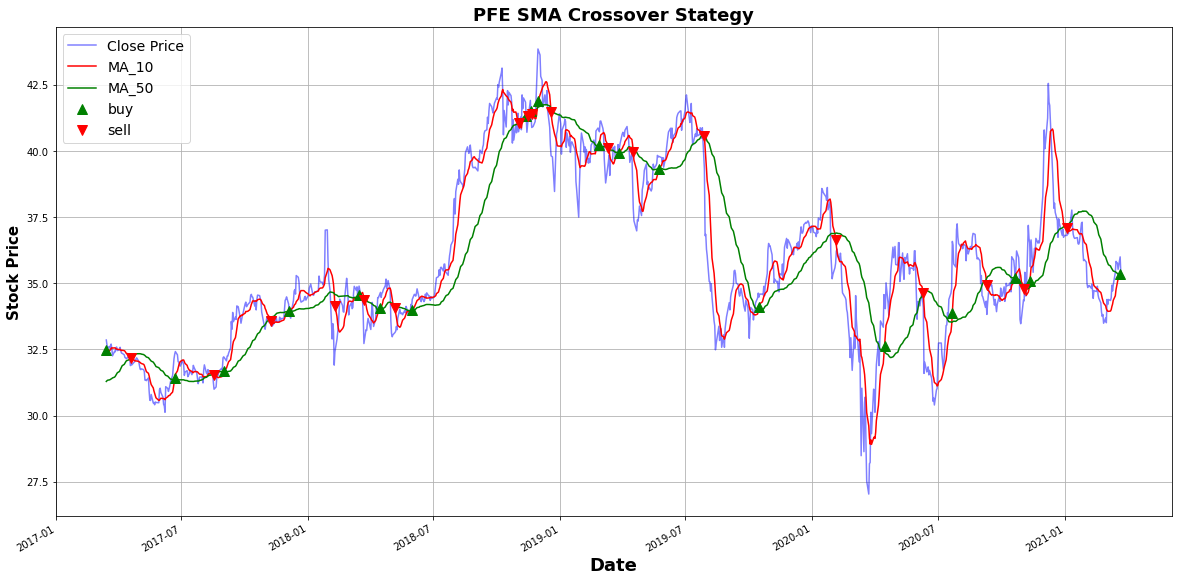

,High,Low,Open,Close,Volume,Adj Close,MA_10,MA_50,Signal,Position
Date,,,,,,,,,,
2017-03-15,32.922199,32.428844,32.466793,32.855785,24279839.0,28.254789,32.485769,31.289754,1.0,1.0
2017-03-16,32.855785,32.495255,32.798862,32.666035,21816219.0,28.091606,32.478179,31.316888,1.0,0.0
2017-03-17,32.808350,32.514233,32.694496,32.561668,45736117.0,28.001856,32.459203,31.336433,1.0,0.0
2017-03-20,32.732449,32.561668,32.637569,32.618595,18435514.0,28.050808,32.462049,31.351044,1.0,0.0
2017-03-21,32.836811,32.428844,32.713470,32.495255,33083479.0,27.944742,32.486717,31.365655,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-03-17,35.959999,35.119999,35.830002,35.790001,42299500.0,35.790001,34.900000,35.397600,0.0,0.0
2021-03-18,35.970001,35.520000,35.529999,35.770000,24716200.0,35.770000,35.057000,35.369200,0.0,0.0
2021-03-19,35.820000,35.470001,35.750000,35.529999,48256600.0,35.529999,35.171000,35.342400,0.0,0.0


In [18]:
sma_data = sma_function(sma_func_calc,col1='Close',col2='MA_10',col3='MA_50',symbol='PFE')
sma_data

#### SMA Subset

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

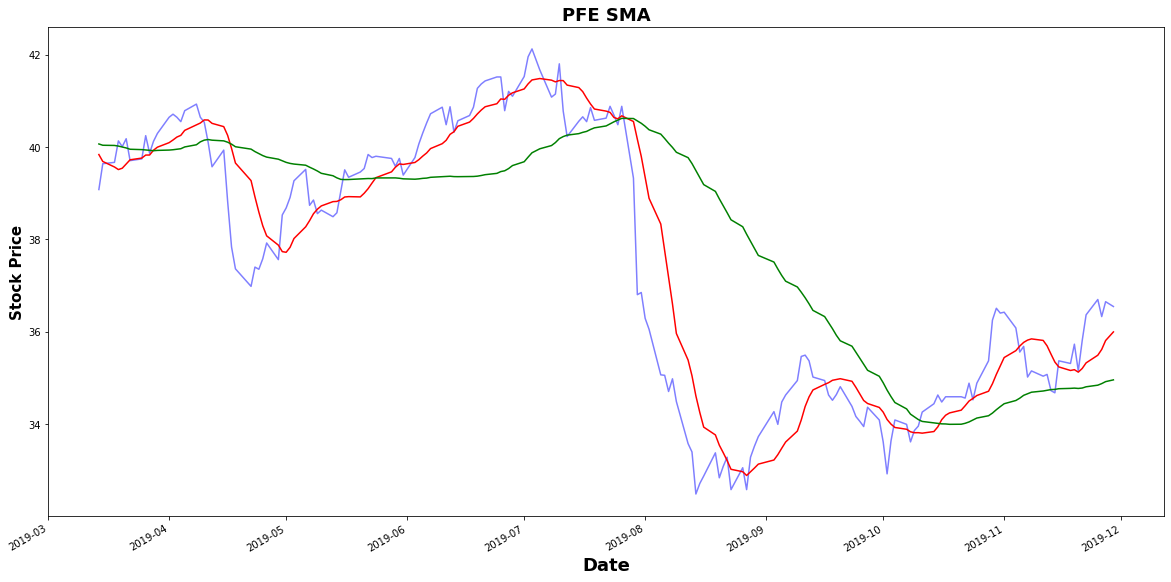

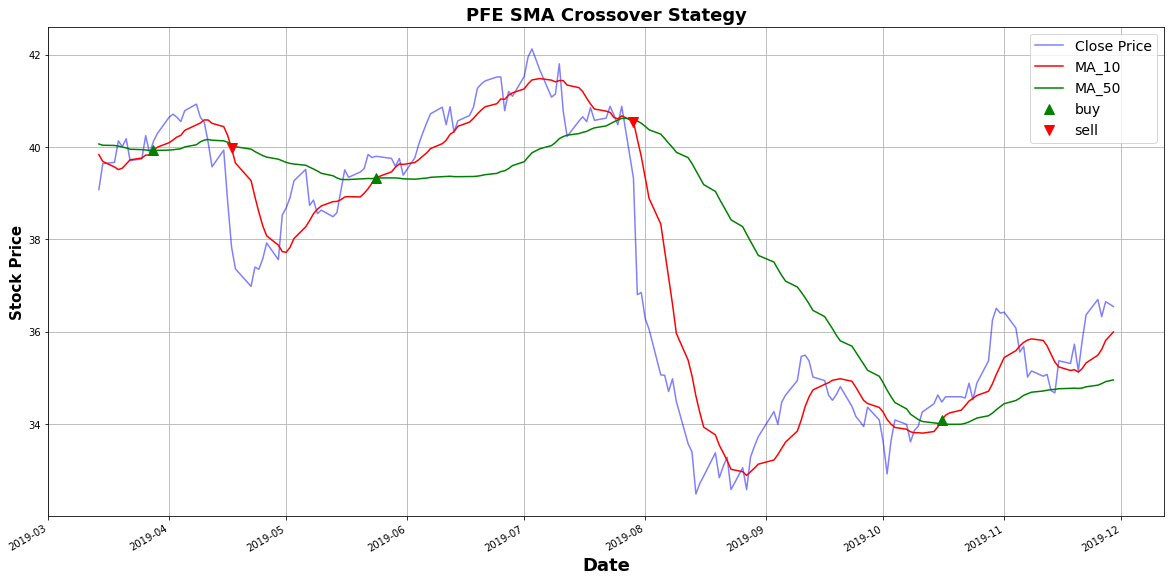

In [19]:
sma_rolling_3 = sma_function(sma_func_calc['2019-01-01':'2019-12-01'],col1='Close',col2='MA_10',col3='MA_50',symbol='PFE')
sma_rolling_3;

In [20]:
print('Close Price')
print(sma_rolling_3['Close'].describe())
print()
print('10 Day Moving Average')
print(sma_rolling_3['MA_10'].describe())
print()
print('50 Day Moving Average')
print(sma_rolling_3['MA_50'].describe())

Close Price
count    182.000000
mean      37.448965
std        2.883637
min       32.485767
25%       34.648956
50%       37.481024
75%       40.241934
max       42.125237
Name: Close, dtype: float64

10 Day Moving Average
count    182.000000
mean      37.531434
std        2.819527
min       32.887096
25%       34.753558
50%       38.369545
75%       40.133302
max       41.483871
Name: MA_10, dtype: float64

50 Day Moving Average
count    182.000000
mean      38.074069
std        2.339954
min       33.995066
25%       35.328084
50%       39.336433
75%       39.943738
max       40.621253
Name: MA_50, dtype: float64


#### Exponential Moving Average (EMA)
 The EMA is also referred to as the exponentially weighted moving average.  The difference between EMA and SMA is that SMA assigns equal weight to all periods.  Whereas, with EMA the latest prices are given higher weights and it assigns lesser weight to past data.  EMA is used more by short term traders because it is quicker to react to price changes compared to SMA which is slower. This technical indicator is used to produce buy and sell signals based on crossovers and divergences from the historical price average.  https://www.investopedia.com/terms/e/ema.asp
 <br>

#### MACD Crossover
Stock market analysts and investors use the Exponential Moving Average Crossover strategy to analyze price trends and predict upcoming change in trends.  A crossover occurs when a faster moving average (i.e. a shorter period moving average) crosses a slower moving average (i.e. a longer period moving average). In stock trading, this meeting point can be used as a potential indicator to buy or sell an asset. When the short term moving average crosses above the long term moving average, this indicates a buy signal. However, when the short term moving average crosses below the long term moving average, it may be a good moment to sell.  The MACD line is calculated by taking the short term exponenrial moving average minus the long term exponetial moving average.  When the red line crosses above the green line you see an increase in the price and every time the red drops below the EMA26 you see the price decrease.<br>When MACD line crosses above the signal line that indicates a good time to buy and when it is below signal line that indcates a time to sell.

Short term moving average usually last 12 periods and long term last 26 periods.  The Signal line is generally a 9 period exponentially smooth average of the MACD line.  This indicator uses two (or more) moving averages — a faster moving average (short-term) and a slower (long-term) moving average.  This program uses the MACD Crossover to determine when to buy and sell stocks.<br>
A short term moving average is faster because it only considers prices over short period of time and is thus more reactive to daily price changes.  Whereas, a long-term moving average is deemed slower as it encapsulates prices over a longer period and a slower response to daily prices.<br>

In [21]:
macd_df_1 = pfe_stock_data.copy()

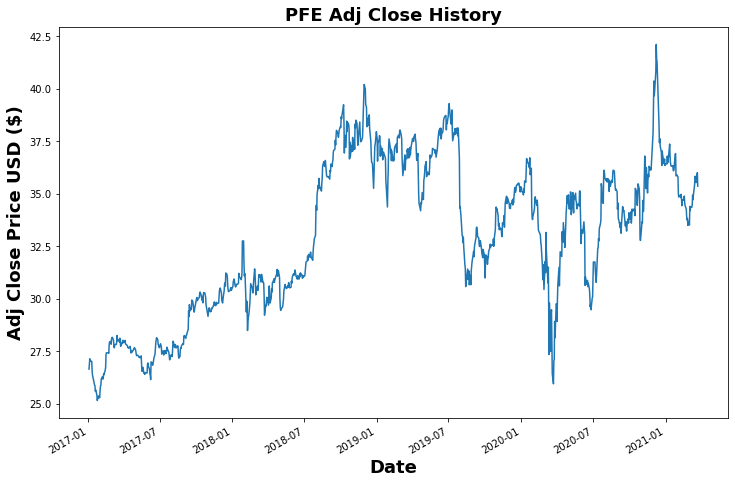

In [22]:
#ema_function(macd_df)
single_plot(macd_df_1, stock_value='Adj Close', stock_symbol='PFE')

#### Exponential Moving Average Crossover Stratergy
Stock market analysts and investors use Exponential Moving Average Crossover strategy, among other moving averages, to analyze price trends and predict upcoming change of trends.  A moving-average crossover occurs when plotting, the two moving averages each based on different time-periods tend to cross. This indicator uses two (or more) moving averages — a faster moving average (short-term) and a slower (long-term) moving average. The faster moving average may be 5-, 10- or 25-day period while the slower moving average can be 50-, 100- or 200-day period.  A short term moving average is faster because it only considers prices over short period of time and is thus more reactive to daily price changes. On the other hand, a long-term moving average is deemed slower as it encapsulates prices over a longer period and is more lethargic.<br>
A crossover occurs when a faster moving average (i.e. a shorter period moving average) crosses a slower moving average (i.e. a longer period moving average). In stock trading, this meeting point can be used as a potential indicator to buy or sell an asset.
When the short term moving average crosses above the long term moving average, this indicates a buy signal.
However, when the short term moving average crosses below the long term moving average, it may be a good moment to sell.<br>

In [23]:
#ewmal_1 = pfe_stock_data.copy() 

In [24]:
# # Create 20 days exponential moving average column
# ewmal_1['20_EMA'] = ewmal_1['Close'].ewm(span = 20, adjust = False).mean()
# # Create 50 days exponential moving average column
# ewmal_1['50_EMA'] = ewmal_1['Close'].ewm(span = 50, adjust = False).mean()

In [25]:
# # create a new column 'Signal' such that if 20-day EMA is greater   # than 50-day EMA then set Signal as 1 else 0
  
# ewmal_1['Signal'] = 0.0  
# ewmal_1['Signal'] = np.where(ewmal_1['20_EMA'] > ewmal_1['50_EMA'], 1.0, 0.0)


In [26]:
# # create a new column 'Position' which is a day-to-day difference of # the 'Signal' column
# ewmal_1['Position'] = ewmal_1['Signal'].diff()

In [27]:
# ewmal_1.head()

In [28]:
# plt.figure(figsize = (20,10))
# # plot close price, short-term and long-term moving averages 
# ewmal_1['Close'].plot(color = 'b', label= 'Close Price') 
# ewmal_1['20_EMA'].plot(color = 'r',label = '20-day EMA') 
# ewmal_1['50_EMA'].plot(color = 'g', label = '50-day EMA')
# # plot ‘buy’ signals
# plt.plot(ewmal_1[ewmal_1['Position'] == 1].index, 
#          ewmal_1['20_EMA'][ewmal_1['Position'] == 1], 
#          '^', markersize = 15, color = 'g', label = 'buy')
# # plot ‘sell’ signals
# plt.plot(ewmal_1[ewmal_1['Position'] == -1].index, 
#          ewmal_1['20_EMA'][ewmal_1['Position'] == -1], 
#          'v', markersize = 15, color = 'r', label = 'sell')
# plt.ylabel('Stock Price', fontsize = 15 )
# plt.xlabel('Date', fontsize = 15 )
# plt.title('Pfizer EWMA Crossover', fontsize = 20)
# plt.legend()
# plt.grid()
# plt.show()

In [29]:
# ewmal_2 = ewmal_1['2018-01-01':'2018-07-01']
# plt.figure(figsize = (20,10))
# # plot close price, short-term and long-term moving averages 
# ewmal_2['Close'].plot(color = 'b', label= 'Close Price') 
# ewmal_2['20_EMA'].plot(color = 'r',label = '20-day EMA') 
# ewmal_2['50_EMA'].plot(color = 'g', label = '50-day EMA')
# # plot ‘buy’ signals
# plt.plot(ewmal_2[ewmal_2['Position'] == 1].index, 
#          ewmal_2['20_EMA'][ewmal_2['Position'] == 1], 
#          '^', markersize = 15, color = 'g', label = 'buy')
# # plot ‘sell’ signals
# plt.plot(ewmal_2[ewmal_2['Position'] == -1].index, 
#          ewmal_2['20_EMA'][ewmal_2['Position'] == -1], 
#          'v', markersize = 15, color = 'r', label = 'sell')
# plt.ylabel('Stock Price', fontsize = 15 )
# plt.xlabel('Date', fontsize = 15 )
# plt.title('Pfizer EWMA Crossover', fontsize = 20)
# plt.legend()
# plt.grid()
# plt.show()

In [30]:
ewmal_2 = pfe_stock_data.copy() 

In [31]:
def ema_function(data, span1=None,span2=None):    
    # Create 20 days exponential moving average column
    data['12_EMA'] = data['Close'].ewm(span = span1, adjust = False).mean()
    # Create 50 days exponential moving average column
    data['26_EMA'] = data['Close'].ewm(span = span2, adjust = False).mean()

    #create a new column 'Signal' such that if 20-day EMA is greater   # than 50-day EMA then set Signal as 1 else 0
    data['Signal'] = 0.0  
    data['Signal'] = np.where(data['12_EMA'] > data['26_EMA'], 1.0, 0.0)

    # create a new column 'Position' which is a day-to-day difference of # the 'Signal' column
    data['Position'] = data['Signal'].diff()

    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data['Close'].plot(color = 'b', label= 'Close Price') 
    data['12_EMA'].plot(color = 'r',label = '12-day EMA') 
    data['26_EMA'].plot(color = 'g', label = '26-day EMA')

    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data['Close'].plot(color = 'b', label= 'Close Price') 
    data['12_EMA'].plot(color = 'r',label = '12-day EMA') 
    data['26_EMA'].plot(color = 'g', label = '26-day EMA')
    # plot ‘buy’ signals
    plt.plot(data[ewmal_2['Position'] == 1].index, 
             data['12_EMA'][ewmal_2['Position'] == 1], 
             '^', markersize = 15, color = 'g', label = 'buy')
    # plot ‘sell’ signals
    plt.plot(data[data['Position'] == -1].index, 
             data['12_EMA'][data['Position'] == -1], 
             'v', markersize = 15, color = 'r', label = 'sell')
    plt.ylabel('Stock Price', fontsize = 15 )
    plt.xlabel('Date', fontsize = 15 )
    plt.title('Pfizer EWMA Crossover', fontsize = 20)
    plt.legend()
    plt.grid()
    
    return data

,Close,Volume,Adj Close,12_EMA,26_EMA,Signal,Position
Date,,,,,,,
2017-01-03,31.309298,23391844.0,26.653324,31.309298,31.309298,0.0,NaN
2017-01-04,31.584440,22753963.0,26.887548,31.351627,31.329679,1.0,1.0
2017-01-05,31.888046,21083584.0,27.146002,31.434153,31.371039,1.0,0.0
2017-01-06,31.764706,18418228.0,27.041008,31.485007,31.400200,1.0,0.0
2017-01-09,31.755219,21559886.0,27.032928,31.526578,31.426497,1.0,0.0
...,...,...,...,...,...,...,...
2021-03-17,35.790001,42299500.0,35.790001,34.962721,34.892665,1.0,1.0
2021-03-18,35.770000,24716200.0,35.770000,35.086918,34.957653,1.0,0.0
2021-03-19,35.529999,48256600.0,35.529999,35.155084,35.000049,1.0,0.0


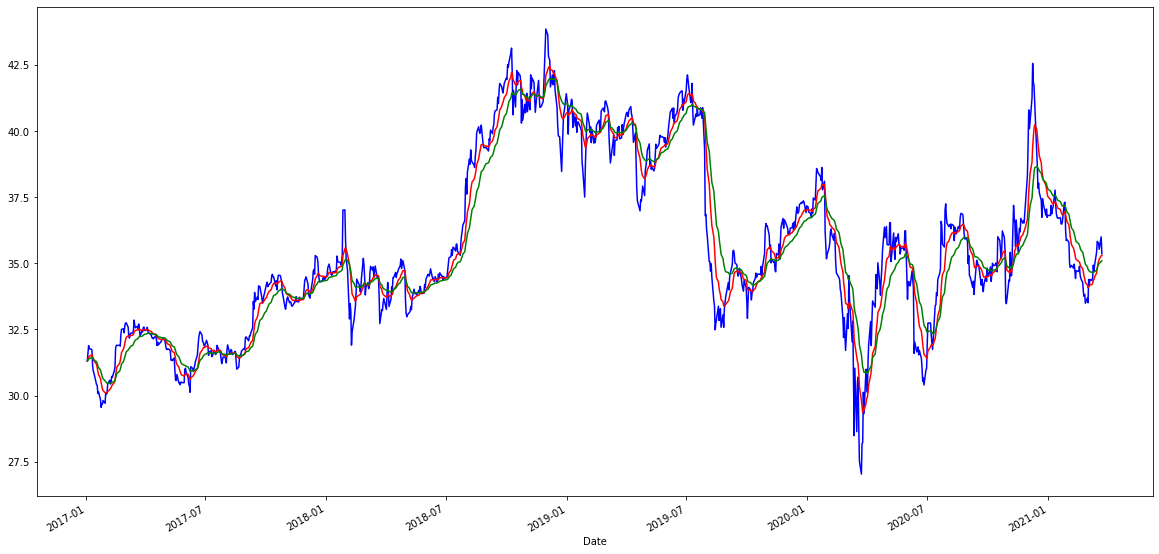

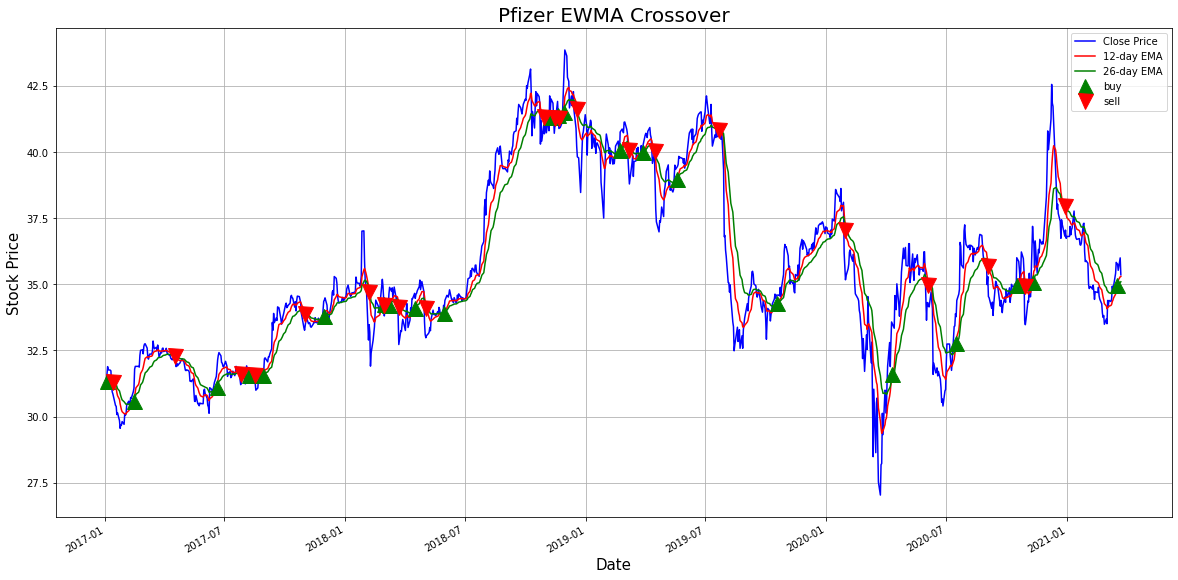

In [32]:
ewm_calc = ema_function(ewmal_2,span1 = 12,span2 = 26)
ewm_calc

In [33]:
#ewm_calc.head()

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



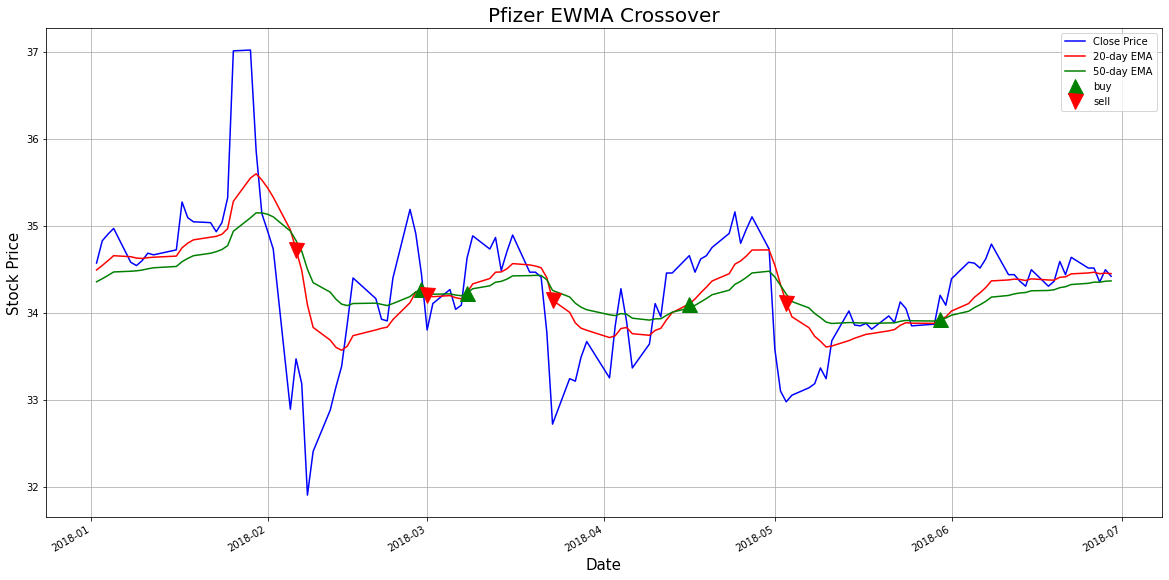

In [34]:
ewmal_3 = ewmal_2['2018-01-01':'2018-07-01']
plt.figure(figsize = (20,10))
# plot close price, short-term and long-term moving averages 
ewmal_3['Close'].plot(color = 'b', label= 'Close Price') 
ewmal_3['12_EMA'].plot(color = 'r',label = '20-day EMA') 
ewmal_3['26_EMA'].plot(color = 'g', label = '50-day EMA')
# plot ‘buy’ signals
plt.plot(ewmal_3[ewmal_2['Position'] == 1].index, 
         ewmal_3['12_EMA'][ewmal_2['Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(ewmal_3[ewmal_3['Position'] == -1].index, 
         ewmal_3['12_EMA'][ewmal_3['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Stock Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Pfizer EWMA Crossover', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

### Rate of Change
The Rate of Change (ROC) is a technical indicator that measures the percentage change between the most recent price and the price a specified number of days before. The indicator fluctuates around the zero line.
#### Historical Price Change Analysis
Volatility is the range of price changes a security experiences over a given period of time. If the price stays relatively stable, the security has low volatility. A highly volatile security hits new highs and lows quickly, moves erratically, and has rapid increases and dramatic falls.  Is volatility in price good or bad for trading? This is a complex question with multiple possible answer.  One possible answer is that as the price fluctuates, it provides the opportunity for investors to buy stock in a solid company when the price is very low, and then wait for cumulative growth down the road.  https://www.investopedia.com/ask/answers/010915/volatility-good-thing-or-bad-thing-investors-point-view-and-why.asp<br>
For short-term traders, volatility is even more crucial. Day traders work with changes that occur second-to-second, minute-to-minute. If there is no price change, there is no profit.https://www.investopedia.com/ask/answers/010915/volatility-good-thing-or-bad-thing-investors-point-view-and-why.asp The column 'change' shows how volatile the price change was percentage wise. The graph shows that the data points are now centered aound 0. The graph shows that around 3/20 was a volatile period for the stock price and it increase above 7% and decreased 7%.



### Price Change in Dollars
To see how big the changes in price were on a daily basis we subtract yesterday's closing price yesterday from today.  This will show the change in price.  A column named 'Actual_Changes' is added to calculate actual change in dollars.<br>For example, we can see that on 1/3/17 the Adj Closing price was 26.653324 and on 1/4/17 the Adj Closing price was 26.887548.  The price change $0.234224.<br> 

Scatterplot of absolute value of magnitude change vs. actual change. Let's us see how the price changes daily.<br>

In [35]:
# sdr = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=False, stock_value='Adj Close')
# sdr
price_change = pfe_stock_data.copy()

In [36]:
#leavr off 1 b/c that's default value
#using shift function
#26.887548 - 26.653324 = 0.234224
def price_change_func(data, col1=None,stock_value=None):
    data['Actual_Changes'] = data[col1] - data[col1].shift(1)
    # price_change['Expected_Changes'] =price_change['Close'] * #std deviation or 21 day 

    data['Actual_Changes'].plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'Historical {stock_value} Price',fontdict=label_font) 
    
    return data

,Close,Volume,Adj Close,Actual_Changes
Date,,,,
2017-01-03,31.309298,23391844.0,26.653324,NaN
2017-01-04,31.584440,22753963.0,26.887548,0.234224
2017-01-05,31.888046,21083584.0,27.146002,0.258453
2017-01-06,31.764706,18418228.0,27.041008,-0.104994
2017-01-09,31.755219,21559886.0,27.032928,-0.008080
...,...,...,...,...
2021-03-17,35.790001,42299500.0,35.790001,-0.040001
2021-03-18,35.770000,24716200.0,35.770000,-0.020000
2021-03-19,35.529999,48256600.0,35.529999,-0.240002


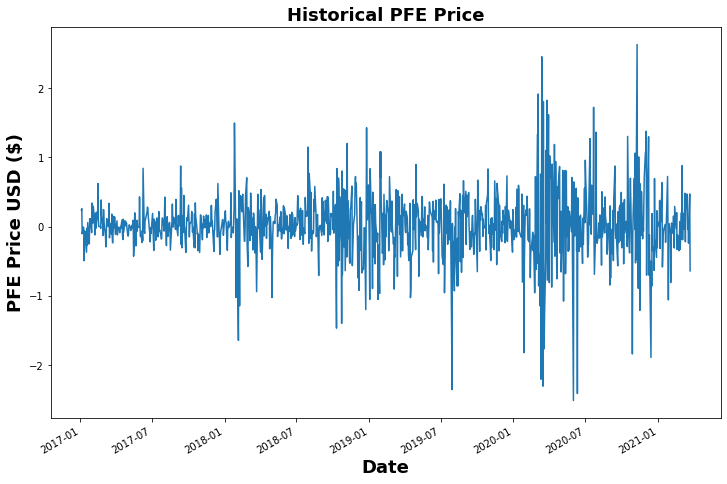

In [37]:
#price_change,
price_change_data = price_change_func(price_change,col1='Adj Close',stock_value='PFE')
price_change_data

The below graph shows that for the stated time the stock price difference was rarely positively more than $2.627 than negatviely more than -2.511.  The average daily return was 0.007375.<br>

In [38]:
#the mean (average) change was less than 1 cent
price_change['Actual_Changes'].describe() 

count    1061.000000
mean        0.008206
std         0.475841
min        -2.511635
25%        -0.180000
50%         0.008556
75%         0.215694
max         2.627960
Name: Actual_Changes, dtype: float64

In [39]:
#single_plot(price_change, stock_value='Actual_Changes',stock_symbol='PFE')

In [40]:
#multi_stocks

In [41]:
multi_price_change = multi_stocks.copy()

MRNA, AZNA, JNJ didn't have a big daily price differece either psotively or negatively. NVAX did have spikes in daily price 
both psotively and negatively. NVAX average stock price is \\$41.94.  Around 2/21, the price spiked to 319.929 and 3.690000.  The price had increased \\$86.930 but then decreased \\$-34.299.<br>

In [42]:
def multi_price_change_func(data):
    data = data - data.shift(1)
    data.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel('Price USD ($)',fontdict=label_font)
    plt.title('Multi-Stock Actual Changes',fontdict=label_font) 
    
    return data

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.234224,-0.169662,0.800001,NaN,0.186050,NaN
2017-01-05,0.258453,1.080444,0.199999,NaN,0.642715,NaN
2017-01-06,-0.104994,-0.500038,1.000000,NaN,-0.219879,NaN
2017-01-09,-0.008080,-0.017860,1.000000,NaN,0.084570,NaN
...,...,...,...,...,...,...
2021-03-17,-0.040001,-0.599991,3.230011,-8.470001,0.020000,-1.439995
2021-03-18,-0.020000,-0.300003,-8.200012,-6.089996,-0.739998,-3.010002
2021-03-19,-0.240002,-0.430008,10.990005,2.279999,-0.120003,3.939995


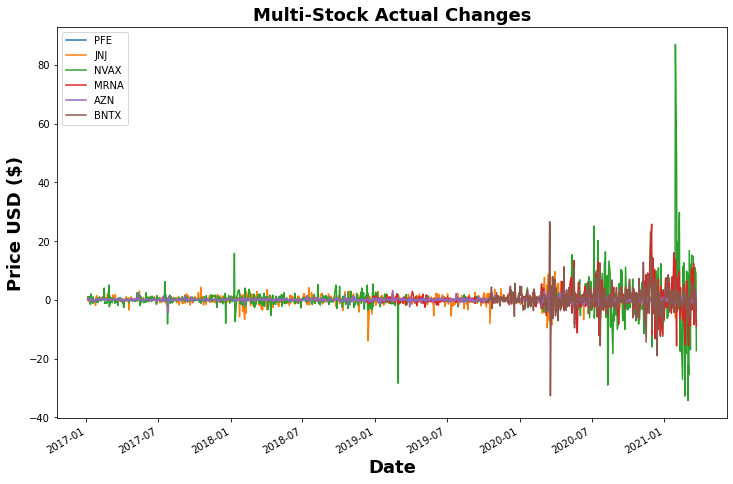

In [43]:
multi_price_calc = multi_price_change_func(multi_price_change)
multi_price_calc

In [44]:
multi_price_calc.describe()

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
count,1061.000000,1061.000000,1061.000000,575.000000,1061.000000,364.000000
mean,0.008206,0.053641,0.183261,0.205078,0.024473,0.235907
std,0.475841,1.723930,5.341044,3.690036,0.683752,4.644587
min,-2.511635,-13.964050,-34.299988,-15.680008,-4.421049,-32.700001
25%,-0.180000,-0.568008,-0.600000,-0.720001,-0.247993,-1.842497
50%,0.008556,0.081429,0.000000,0.020000,0.028324,0.115002
75%,0.215694,0.797493,0.799999,1.030000,0.304558,2.329999
max,2.627960,9.590652,86.930008,25.710007,3.912495,26.599998


In [45]:
def hist_func_actual(data, col=None):
    plt.figure(figsize=(12,8))
    data[col].hist(bins=50)
    plt.title('Histogram of Daily Returns Distribution')
    plt.xlabel('Actual Change')
    plt.ylabel('Frequency')

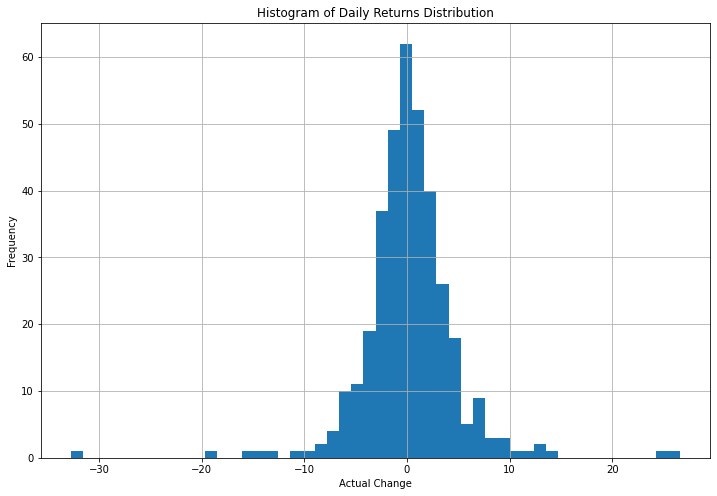

In [46]:
hist_func_actual(multi_price_calc, col='BNTX')

### Simple Daily Return
Daily price change as a percentage

In [47]:
multi_stocks.head()

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,103.436539,25.400000,NaN,23.433638,NaN
2017-01-04,26.887548,103.266876,26.200001,NaN,23.619688,NaN
2017-01-05,27.146002,104.347321,26.400000,NaN,24.262403,NaN
2017-01-06,27.041008,103.847282,27.400000,NaN,24.042524,NaN
2017-01-09,27.032928,103.829422,28.400000,NaN,24.127094,NaN


In [48]:
(26.887548 /26.653324) -1

0.008787796974216056

In [49]:
#new price(cuurent time period) /old price - 1
#26.887548 - 26.653324=
#(26.200001 /25.400000) -1
def multi_price_change_func(data):
    daily_simple_returns = data.pct_change(1) #1 is for 1 day
    daily_simple_returns.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel('Price USD ($)',fontdict=label_font)
    plt.title('Multi-Stock Actual Changes',fontdict=label_font) 
    
    return daily_simple_returns

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.008788,-0.001640,0.031496,NaN,0.007939,NaN
2017-01-05,0.009612,0.010463,0.007634,NaN,0.027211,NaN
2017-01-06,-0.003868,-0.004792,0.037879,NaN,-0.009063,NaN
2017-01-09,-0.000299,-0.000172,0.036496,NaN,0.003518,NaN
...,...,...,...,...,...,...
2021-03-17,-0.001116,-0.003718,0.014535,-0.054288,0.000400,-0.013321
2021-03-18,-0.000559,-0.001866,-0.036370,-0.041274,-0.014779,-0.028221
2021-03-19,-0.006710,-0.002680,0.050585,0.016118,-0.002433,0.038012


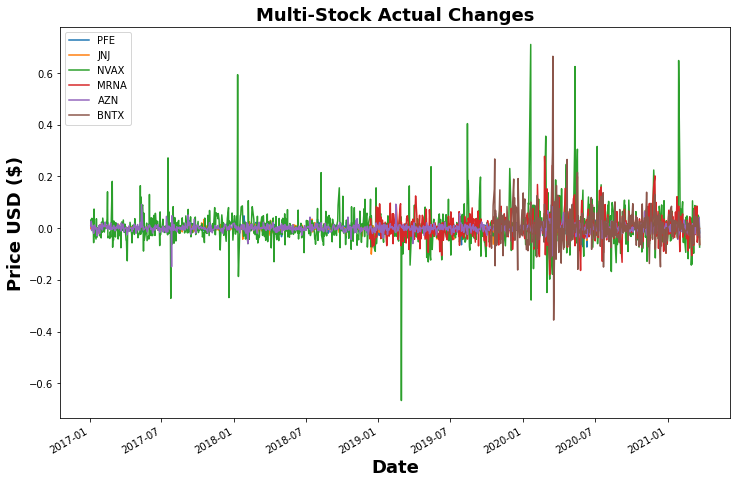

In [50]:
multi_dsr = multi_price_change_func(multi_stocks)
multi_dsr

In [51]:
#mean of daily simple return
#highest return should be NBTX and lowest for PFE
mean_dsr = multi_dsr.mean()
print('The Daily Mean Simple Return')
mean_dsr

The Daily Mean Simple Return


PFE     0.000370
JNJ     0.000501
NVAX    0.004913
MRNA    0.004806
AZN     0.000840
BNTX    0.008161
dtype: float64

In [52]:
def hist_func(data, col=None):
    plt.figure(figsize=(12,8))
    multi_dsr[col].hist(bins=50)
    plt.title('Histogram of Daily Returns Distribution')
    plt.xlabel('Daily Returns')
    plt.ylabel('Frequency')

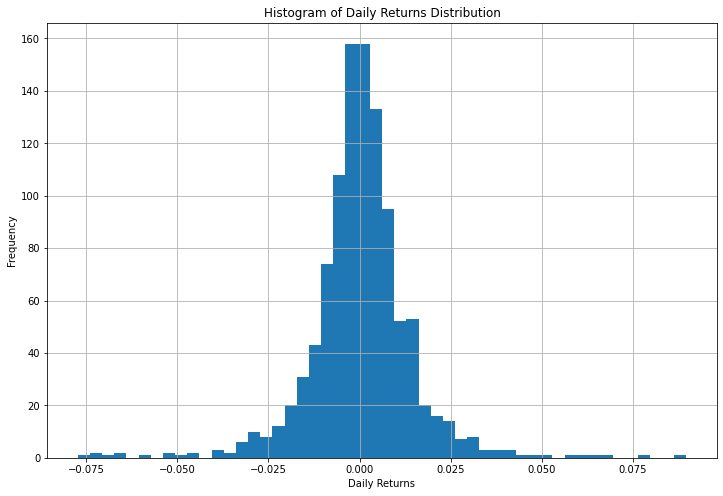

In [53]:
hist_func(multi_dsr, col='PFE')

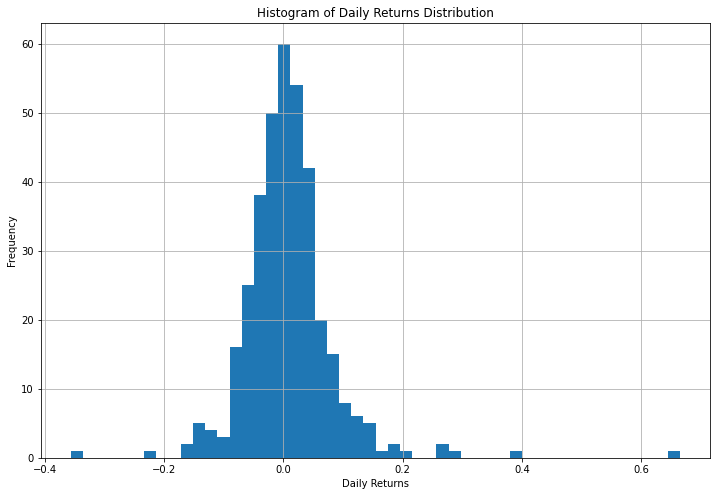

In [54]:
hist_func(multi_dsr, col='BNTX')

In [55]:
36.551258 - 37.603287

-1.0520290000000045

In [56]:
#stock volatility
#print standard deviaiton for daily simple return
#volatility is standard deviation
#Most volatile stock is NVAX, least volatile stock is JNJ
#the higher the volaitility the higher hte return, the lower volatility the lower return
#expect a lower return for JNJ as opposed to BNTX
print('The Stock Volatility')
multi_dsr.std()

The Stock Volatility


PFE     0.014408
JNJ     0.013250
NVAX    0.077076
MRNA    0.052333
AZN     0.016501
BNTX    0.077457
dtype: float64

### Historical Volatility

In [57]:
# #use  rolling standard deviation to get that 
# #use 21 day rolling window b/c there are 21 traing days in a month on average
# #this will include 21st observation
# #but volatility should be used from next day
# prct_change['Volatility'] = prct_change['change'].rolling(21).std().shift(1)

In [58]:
# #what price volatility looks like over time
# #4/20 was a highly volatile period
# prct_change['Volatility'].plot()

### Relative Strength Index (RSI)
The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100.  An asset is usually considered overbought when the value is above 70% and oversold when it is below 30%.  
https://www.investopedia.com/terms/r/rsi.asp Overbought refers that the bubble created from the buying might pop soon, and therefore the price will drop. This creates a strong entry point.  interpretation of the RSI is that values of 70 or above indicate that a security is becoming overvalued or overbought and may be due for a trend reversal or correction in price. An RSI value of 30 or below indicates an undervalued or oversold scenario.<br>
<br>
7/19-RSI value dips below 10 indicator, the 10 significant level.
    Tells us stock was oversold and presents a buying opportunity
On Adj Close plot was see that around 7/19 the price dipped from around \\$40.00 to \\$30.00.
    Then the price increased significantly again.
If you followed RSI you wuold have prucahsed around \\$30.00 and prcie jumped to \\$37.5 around 1/20.    

Around 7/18 to 9/18- Looks like stock was being over bought.  RSI value passed 80 level significant indicator.
    price was around \\$38.00 to \\$40.00.
    Pricde did drop to almost $35.00. Would have been a good time to drop prior to the drop.
    Would have saved some money from selling

In [59]:
rsi_df = pfe_stock_data.copy()
rsi_df

,Close,Volume,Adj Close
Date,,,
2017-01-03,31.309298,23391844.0,26.653324
2017-01-04,31.584440,22753963.0,26.887548
2017-01-05,31.888046,21083584.0,27.146002
2017-01-06,31.764706,18418228.0,27.041008
2017-01-09,31.755219,21559886.0,27.032928
...,...,...,...
2021-03-17,35.790001,42299500.0,35.790001
2021-03-18,35.770000,24716200.0,35.770000
2021-03-19,35.529999,48256600.0,35.529999


In [62]:
def rsi_function(data, col=None):
    rsi_d = data[col].diff(1)
    rsi_d = rsi_d.dropna()
    #get the postive gains (up) and negative gains(down)
    up = rsi_d.copy()
    down = rsi_d.copy()
    #get the postive values in delta
    up[up < 0]=0  #for any values in up that are less than 0. Any values n up that are less than 0, we'll set to 0
    down[down > 0]=0  #values in down that are greater than 0, they're positive. Set those values equal to 0.
    #up only contins positve values and down only contains negative values
    #Get the time period.  RSI is usually 14 day period
    period=14
    #calculate the average gain and average loss
    AVG_gain = up.rolling(window=period).mean()
    AVG_loss = abs(down.rolling(window=period).mean()) #going to be negative values so use absolute
    #calcualte RSI
    #calcualte relative strength (Rs)
    RS = AVG_gain / AVG_loss
    #calcualte relative strength Index (RSI)
    RSI = 100.0 - (100.0 / (1.0 + RS))
    #new dataframe
    new_df = pd.DataFrame()
    new_df[col] = rsi_df[col]
    new_df['RSI'] = RSI
    
    #plot column
    plt.figure(figsize=(12,8))
    plt.plot(new_df.index, new_df[col])
    plt.title(f'{col} Price History for Pfizer')
    plt.legend(new_df.columns.values, loc='upper left')
    #plot RSI values and signficant levels
    plt.figure(figsize=(12,8))
    plt.title('RSI')
    plt.plot(new_df.index,new_df['RSI'])
    plt.axhline(0, linestyle='--', alpha=0.5,color='gray')
    plt.axhline(10, linestyle='--', alpha=0.5,color='orange')
    plt.axhline(20, linestyle='--', alpha=0.5,color='green')
    plt.axhline(30, linestyle='--', alpha=0.5,color='red')
    plt.axhline(70, linestyle='--', alpha=0.5,color='red')
    plt.axhline(80, linestyle='--', alpha=0.5,color='green')
    plt.axhline(90, linestyle='--', alpha=0.5,color='orange')
    plt.axhline(100, linestyle='--', alpha=0.5,color='gray')
    
    return new_df

,Adj Close,RSI
Date,,
2017-01-03,26.653324,NaN
2017-01-04,26.887548,NaN
2017-01-05,27.146002,NaN
2017-01-06,27.041008,NaN
2017-01-09,27.032928,NaN
...,...,...
2021-03-17,35.790001,74.811091
2021-03-18,35.770000,81.147493
2021-03-19,35.529999,74.864811


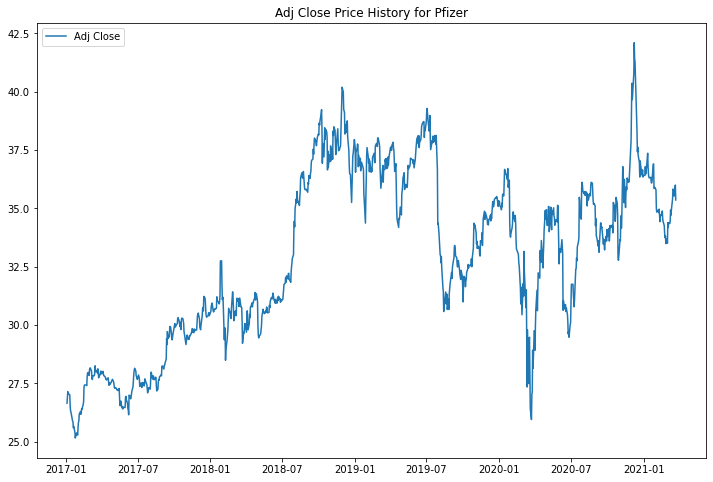

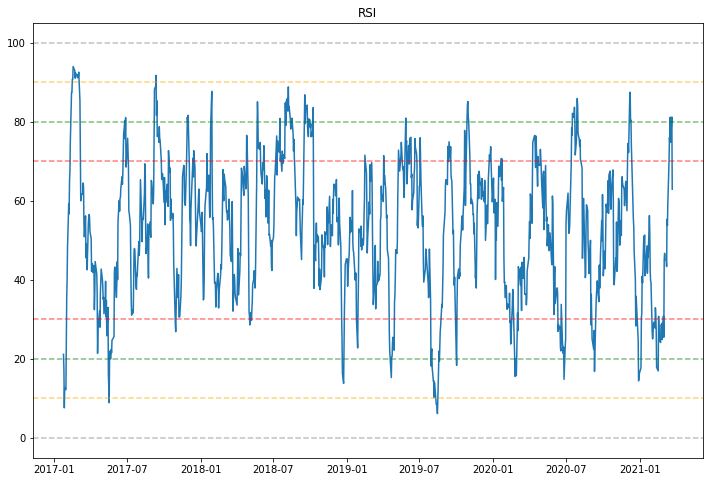

In [63]:
rsi_function(rsi_df, col='Adj Close')

## Question 2: How well can historical data and algorithms predict future stocks prices? 
This section focuses on using Long Short Term Memory (LSTM) and SARIMA models to predict future stock prices.

In [ ]:
#start='01-01-2019',end='today',
#df_single = single_stock_data('PFE', start='01-01-2019',end='today',plot=True,stock_value='Adj Close')

## Sarima Model

In [ ]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

import statsmodels.api as sm

In [ ]:
sarima_data = pfe_stock_data.copy()

In [ ]:
def delta_data(data,col=None):
    data['Actual_Changes'] = data[col] - data[col].shift(1)
    data['Percent_Chg'] = data[col].pct_change(1)
    data['MA_50'] = data[col].rolling(50).mean()
    data = data.dropna()
    return data

In [ ]:
sarima_df = delta_data(sarima_data,col='Adj Close')#delta_time_series(multi_stocks, col='Adj Close')

In [ ]:
sarima_df

##### Train/Test Split

In [ ]:
#training_data_len, dataset, scaler, scaled_data = preprocessing(df_data['Adj Close'], percentage=.8)
n = int(len(sarima_df) * 0.8)
train = sarima_df[:n]
test = sarima_df[n:]

##### ARIMA Model

In [ ]:
def arima_model(df):
    """
    df- dataframe
    function is a gridsearch to get optimal p,d,qs and lowest AIC for the model.
    q-is moving average
    """
    autoarima_model = auto_arima(df, start_p = 0, start_q = 0, #start_q = 0
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = None,               # let model determine 'd', was 1
                              seasonal = True, 
                              start_P=0, D=1, trace = False, #start  #trace= True
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    #print('\n')
    #display(autoarima_model.summary())
    
    return autoarima_model


###### ARIMA / Adj Close

In [ ]:
sarima_col = 'Adj Close'

In [ ]:
stepwise_fit = arima_model(train[sarima_col])

In [ ]:
stepwise_fit.summary()

In [ ]:
arima_list = [['hist', 'pdq','seasonal_pdq','aic']] 
for col in sarima_df.columns:
  zip_test_2 = arima_model(sarima_df[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

In [ ]:
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

In [ ]:
#train['Adj Close'][[0,-1]]
train[sarima_col][[0,-1]]

In [ ]:
#test['Adj Close'][[0,-1]]
test[sarima_col][[0,-1]]

In [ ]:
hist_type = sarima_col #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
plt.figure(figsize=(12,6))
# Plot observed values

#ax = train['Adj Close']['2019':].plot(label='observed')
ax = train[sarima_col]['2019':].plot(label='observed')#
#test['Adj Close']['2019':].plot()#label='Test'
test[sarima_col]['2019':].plot()#label='Test'
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()

In [ ]:
# Get the real and predicted values
forecast = pred.predicted_mean
actual =test[sarima_col]['1996':] #actual =test['Adj Close']['1996':]

# Compute the root mean square error
mse = ((forecast - actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast - actual) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [ ]:
history_type = sarima_col #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
def prediction_vis(pred_dynamic,pred_dynamic_conf, y):
  # Plot the dynamic forecast with confidence intervals.
  plt.figure(figsize=(12,5))
  # Plot observed values
  ax = y.plot(label='Observed')

  # Plot predicted values
  pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(pred_dynamic_conf.index,
                  pred_dynamic_conf.iloc[:, 0],
                  pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Sale Price')
  plt.legend()

  return ax

In [ ]:
prediction_visual = prediction_vis(pred_dynamic,pred_dynamic_conf,train[history_type])
prediction_visual

In [ ]:
# Get the real and predicted values
forecast = pred_dynamic.predicted_mean
actual = train[history_type]#['1996':]

# Compute the mean square error
mse = ((forecast - actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast - actual) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [ ]:
sarima_col_1 = 'MA_50'

In [ ]:
#stepwise_fit = arima_model(train['Adj Close'])
stepwise_fit = arima_model(train[sarima_col])

In [ ]:
stepwise_fit.summary()

In [ ]:
arima_list = [['hist', 'pdq','seasonal_pdq','aic']] 
for col in sarima_df.columns:
  zip_test_2 = arima_model(sarima_df[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

In [ ]:
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

In [ ]:
#train['Adj Close'][[0,-1]]
train[sarima_col_1][[0,-1]]

In [ ]:
#test['Adj Close'][[0,-1]]
test[sarima_col_1][[0,-1]]

In [ ]:
hist_type = sarima_col_1 #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
plt.figure(figsize=(12,6))
# Plot observed values

#ax = train['Adj Close']['2019':].plot(label='observed')
ax = train[sarima_col_1]['2019':].plot(label='observed')#
#test['Adj Close']['2019':].plot()#label='Test'
test[sarima_col_1]['2019':].plot()#label='Test'
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()

In [ ]:
# Get the real and predicted values
forecast = pred.predicted_mean
actual =test[sarima_col_1]['1996':] #actual =test['Adj Close']['1996':]

# Compute the root mean square error
mse = ((forecast - actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast - actual) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [ ]:
history_type = sarima_col_1 #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
def prediction_vis(pred_dynamic,pred_dynamic_conf, y):
  # Plot the dynamic forecast with confidence intervals.
  plt.figure(figsize=(12,5))
  # Plot observed values
  ax = y.plot(label='Observed')

  # Plot predicted values
  pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(pred_dynamic_conf.index,
                  pred_dynamic_conf.iloc[:, 0],
                  pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Sale Price')
  plt.legend()

  return ax

In [ ]:
prediction_visual = prediction_vis(pred_dynamic,pred_dynamic_conf,train[history_type])
prediction_visual

In [ ]:
# # Get the real and predicted values
# forecast_11238 = pred_dynamic.predicted_mean
# truth_11238 = train[current_zip]#['1996':]

# # Compute the mean square error
# mse = ((forecast_11238 - truth_11238) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
# #np.sqrt(np.mean((predictions-targets)**2))
# rmse = np.sqrt(np.mean((forecast_11238 - truth_11238) ** 2))
# print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [ ]:
# Get the real and predicted values
forecast = pred_dynamic.predicted_mean
actual = train[history_type]#['1996':]

# Compute the mean square error
mse = ((forecast - actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast - actual) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

### LTSM / Multi-Stocks


In [ ]:
multi_stocks

In [ ]:
def delta_time_series(data,col=None):
#     data['Actual_Changes'] = data['Close'] - data['Close'].shift(1)
#     data['Percent_Chg'] = data[col].pct_change(1)
#     data['MA_50'] = data[col].rolling(50).mean()
    data = data.dropna()
    return data

In [ ]:
multi = delta_time_series(multi_stocks, col='Adj Close')
multi

In [ ]:
multi.shape

In [ ]:
def plot_delta(data,col=None,symbol=None):
    #plt.figure(figsize=(12,6))
    #plt.plot(delta_time_series(data))
    data.plot(figsize=(12,6))
    label_font = {'weight':'bold','size':18}
    plt.title('Daily Percentage Price Change',fontdict=label_font)
    plt.xlabel('Dates',fontdict=label_font)
    plt.ylabel('close')
    plt.show()

In [ ]:
#simple daily return
#centered aroun d 0
plot_delta(multi)

In [ ]:
def get_y_from_df(train_scaled_df, look_back, col='PFE', ):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

#### Train Test Split

In [ ]:
train_size = int(len(multi) * 0.80)#0.67
test_size = len(multi) - train_size

In [ ]:
multi.index[train_size]

In [ ]:
multi.index[-test_size]


In [ ]:
def train_test_val(single_stock, date1='2020-09-11', date2='2020-11-01'):    
    train = single_stock[:date1]#'2020-09-11'
    val = single_stock[date1:date2]
    test = single_stock[date2:] #2021-02-12
    ax = train.plot(figsize=(12,8))
    val.plot(ax=ax)
    test.plot(ax=ax)
    
    return train, val, test

In [ ]:
train, val, test= train_test_val(multi)

#### Normalize Data

In [ ]:
def scale_function(train, test,val):
# normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    val_scaled = scaler.transform(val)
    
    return scaler, train_scaled,test_scaled, val_scaled

In [ ]:
scaler, train_scaled, test_scaled, val_scaled = scale_function(train,test,val)

In [ ]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=val.columns, index=val.index)

In [ ]:
train_scaled_df.shape, val_scaled_df.shape, test_scaled_df.shape

In [ ]:
look_back = 3
batch_size=3
col_index = {v:k for k,v in enumerate(train_scaled_df.columns)}
col_index

In [ ]:
col_index['PFE']

#### Timeseries Generator

In [ ]:
def generator_function(train_scaled_df, val_scaled_df, test_scaled_df, col=None):
    train_data_gen = TimeseriesGenerator(train_scaled_df.values, train_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    val_data_gen = TimeseriesGenerator(val_scaled_df.values, val_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    test_data_gen = TimeseriesGenerator(test_scaled_df.values, test_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=3)
    
    ex_X, ex_y = train_data_gen[0]
    #ex_X.shape
    
    return train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y

In [ ]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='PFE')

In [ ]:
# ex_X, ex_y = train_data_gen[0]
# ex_X.shape

In [ ]:
sample = ex_X[0]
sample.shape

In [ ]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()    

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model.fit_generator(train_data_gen, epochs=25,validation_data=val_data_gen,callbacks=[early_stop])

In [ ]:
model.evaluate_generator(test_data_gen)

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
def save_model(model):
    model.save('model_parameters')
    model_params = keras.models.load_model('model_parameters')
    model_params.summary()

    return model_params

In [ ]:
# model_params = save_model(model)

In [ ]:
trainPredict = model.predict_generator(train_data_gen)
trainPredict.shape

In [ ]:
testPredict = model.predict_generator(test_data_gen)
testPredict.shape

In [ ]:
y_hat_train = pd.Series(trainPredict.flatten(),index=train.index[look_back:])
len(y_hat_train)

In [ ]:
#y_hat_train = pd.Series(testPredict.
y_hat_test = pd.Series(testPredict.flatten(),index=test.index[look_back:])
len(y_hat_test)

In [ ]:
y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

#### RMSE Function

In [ ]:
def model_metrics(y_train,y_hat_train):
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train, y_hat_train))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, y_hat_test))
    print('Test Score: %.2f RMSE' % (testScore))
    
    return trainScore, testScore

In [ ]:
#a value of 0 means predcitions were exact
#models got values exactly as they were supposed to from testing data
#what in normalized
model_metrics(y_train,y_hat_train)

#### Prediction Plot

In [ ]:
#red what th model actually predicted
def prediction_plot(y_train,y_test,y_val,y_hat_test):
    plt.figure(figsize=(12,6))
    y_train.plot(label='train')
    y_test.plot(label='test')
    y_val.plot(label='val')
    y_hat_test.plot(label='Prediction')
    #lt.legend(['Valid','Train','Predictions'],loc='uppper left')
    plt.legend()
    

In [ ]:
prediction_plot(y_train,y_test,y_val,y_hat_test)

### LTSM / Single Stock

In [ ]:
#df_single.to_csv('single_stock')

# single = pd.read_csv('single_stock', parse_dates=True, index_col='Date')
# single

In [ ]:
# pfe_stock_data
pfe_stock_data

In [ ]:
def delta_time_series1(data,col=None):
    data['Actual_Changes'] = data['Close'] - data['Close'].shift(1)
    data['Percent_Chg'] = data[col].pct_change(1)
    data['MA_50'] = data[col].rolling(50).mean()
    data = data.dropna()
    return data

In [ ]:
single = delta_time_series1(pfe_stock_data, col='Adj Close')
single

In [ ]:
def get_y_from_df(train_scaled_df, look_back, col='Adj Close', ):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [ ]:
train_size = int(len(single) * 0.80)#0.67
test_size = len(single) - train_size

In [ ]:
def train_test_val(single_stock, date1='2020-09-11', date2='2020-11-01'):    
    train = single_stock[:date1]#'2020-09-11'
    val = single_stock[date1:date2]
    test = single_stock[date2:] #2021-02-12
    ax = train.plot()
    val.plot(ax=ax)
    test.plot(ax=ax)
    
    return train, val, test

In [ ]:
train, val, test= train_test_val(single)

In [ ]:
def scale_function(train, test,val):
# normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    val_scaled = scaler.transform(val)
    
    return scaler, train_scaled,test_scaled, val_scaled

In [ ]:
scaler, train_scaled, test_scaled, val_scaled = scale_function(train,test,val)

In [ ]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=val.columns, index=val.index)

In [ ]:
train_scaled_df.shape, val_scaled_df.shape, test_scaled_df.shape

In [ ]:
look_back = 3
batch_size=3
col_index = {v:k for k,v in enumerate(train_scaled_df.columns)}
col_index

In [ ]:
def generator_function(train_scaled_df, val_scaled_df, test_scaled_df, col=None):
    train_data_gen = TimeseriesGenerator(train_scaled_df.values, train_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    val_data_gen = TimeseriesGenerator(val_scaled_df.values, val_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    test_data_gen = TimeseriesGenerator(test_scaled_df.values, test_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=3)
    
    ex_X, ex_y = train_data_gen[0]
    #ex_X.shape
    
    return train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y

In [ ]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='Adj Close')

In [ ]:
sample = ex_X[0]
sample.shape

In [ ]:
model1 = Sequential()

model1.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model1.add(Dropout(0.2))

model1.add(LSTM(units = 50, return_sequences = True))
model1.add(Dropout(0.2))

model1.add(LSTM(units = 50, return_sequences = False))
model1.add(Dropout(0.2))

model1.add(Dense(units = 25,activation='relu'))
model1.add(Dense(units = 1))

model1.compile(optimizer = 'adam', loss = 'mean_squared_error')

model1.summary()    

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model1.fit_generator(train_data_gen, epochs=25,validation_data=val_data_gen,callbacks=[early_stop])

In [ ]:
model1.evaluate_generator(test_data_gen)

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
trainPredict = model1.predict_generator(train_data_gen)
trainPredict.shape

In [ ]:
testPredict = model1.predict_generator(test_data_gen)
testPredict.shape

In [ ]:
y_hat_train = pd.Series(trainPredict.flatten(),index=train.index[look_back:])
len(y_hat_train)

In [ ]:
#y_hat_train = pd.Series(testPredict.
y_hat_test = pd.Series(testPredict.flatten(),index=test.index[look_back:])
len(y_hat_test)

In [ ]:
y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [ ]:
def model_metrics(y_train,y_hat_train):
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train, y_hat_train))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, y_hat_test))
    print('Test Score: %.2f RMSE' % (testScore))
    
    return trainScore, testScore

In [ ]:
#what in normalized
model_metrics(y_train,y_hat_train)

In [ ]:
def prediction_plot(y_train,y_test,y_val,y_hat_test):
    plt.figure(figsize=(12,6))
    y_train.plot(label='train')
    y_test.plot(label='test')
    y_val.plot(label='val')
    y_hat_test.plot(label='Prediction')
    #lt.legend(['Valid','Train','Predictions'],loc='uppper left')
    plt.legend()
    

In [ ]:
prediction_plot(y_train,y_test,y_val,y_hat_test)

### LTSM and Technical Indicators

#### Percent_Chg

In [ ]:
#train_scaled_df.columns

#single

In [ ]:
col_index['MA_50']

In [ ]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='MA_50')

In [ ]:
sample = ex_X[0]
sample.shape

In [ ]:
model2 = Sequential()

model2.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model2.add(Dropout(0.2))

model2.add(LSTM(units = 50, return_sequences = True))
model2.add(Dropout(0.2))

model2.add(LSTM(units = 50, return_sequences = False))
model2.add(Dropout(0.2))

model2.add(Dense(units = 25))
model2.add(Dense(units = 1))

model2.compile(optimizer = 'adam', loss = 'mean_squared_error')

model2.summary()    

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model2.fit_generator(train_data_gen, epochs=50,validation_data=val_data_gen,callbacks=[early_stop])

In [ ]:
model2.evaluate_generator(test_data_gen)

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
def get_y_from_df(train_scaled_df, look_back, col='MA_50'):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [ ]:
#look_back=3

In [ ]:
trainPredict = model2.predict_generator(train_data_gen)
#trainPredict.shape
testPredict = model2.predict_generator(test_data_gen)
#testPredict.shape
y_hat_train = pd.Series(trainPredict.flatten(),index=train_scaled_df.index[look_back:])
y_hat_test = pd.Series(testPredict.flatten(),index=test_scaled_df.index[look_back:])

y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [ ]:
model_metrics(y_train,y_hat_train)

In [ ]:
model_metrics(y_test,y_hat_test)

In [ ]:
# plt.figure(figsize=(12,6))
# y_train.plot(label='train')
# y_test.plot(label='test')
# y_val.plot(label='val')
# y_hat_test.plot(label='Prediction')
# #lt.legend(['Valid','Train','Predictions'],loc='uppper left')
# plt.legend()
prediction_plot(y_train,y_test,y_val,y_hat_test)

### Actual_change

In [ ]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='Actual_Changes')

In [ ]:
model3 = Sequential()

model3.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model3.add(Dropout(0.2))

model3.add(LSTM(units = 50, return_sequences = True))
model3.add(Dropout(0.2))

model3.add(LSTM(units = 50, return_sequences = False))
model3.add(Dropout(0.2))

model3.add(Dense(units = 25, activation='relu'))
model3.add(Dense(units = 1))

model3.compile(optimizer = 'adam', loss = 'mean_squared_error')

model3.summary()    

In [ ]:
hist = model3.fit_generator(train_data_gen, epochs=50,validation_data=val_data_gen,
                           callbacks=[early_stop])

In [ ]:
model3.evaluate_generator(test_data_gen)

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
def get_y_from_df(train_scaled_df, look_back, col='Actual_Changes'):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [ ]:
plt.plot(trainPredict)

In [ ]:
trainPredict = model3.predict_generator(train_data_gen)
#trainPredict.shape
testPredict = model3.predict_generator(test_data_gen)
#testPredict.shape
y_hat_train = pd.Series(trainPredict.flatten(),index=train_scaled_df.index[look_back:])
y_hat_test = pd.Series(testPredict.flatten(),index=test_scaled_df.index[look_back:])

y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [ ]:
model_metrics(y_train,y_hat_train)

In [ ]:
prediction_plot(y_train,y_test,y_val,y_hat_test)